## Influence of Opinion Dynamics on Basic SIR Model

Importing necessary files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.ticker import ScalarFormatter


Softmax

In [2]:
def pii(q):
    return 1 / (1 + np.exp(-q)), np.exp(-q) / (1 + np.exp(-q))

Transition Matrix

In [3]:
def transition_matrix(beta, gamma, statevector, q):
    n = len(q)
    matrix_size = 3 * n
    matrix = np.zeros((matrix_size, matrix_size))

    N = np.sum(statevector)
    ps = statevector[:n] / N
    pi = statevector[n:2*n] / N
    pr = statevector[2*n:3*n] / N

    pii1_vals, pii2_vals = pii(q)

    # Fill the matrix according to the pattern
    for i in range(n):
        for j in range(n):
            # S_i -> S_j
            matrix[i, j] = ps[j] + pi[j] * (pii1_vals[i] * (1-beta) + pii2_vals[i]) + pr[j]
            # S_i -> I_j
            matrix[i, n+j] = pi[j] * pii1_vals[i] * beta
        
        for j in range(n):
            # I_i -> I_j
            matrix[n+i, n+j] = (1-gamma) * (ps[j] + pi[j] + pr[j])
            # I_i -> R_j
            matrix[n+i, 2*n+j] = gamma * (ps[j] + pi[j] + pr[j])
        
        for j in range(n):
            # R_i -> R_j
            matrix[2*n+i, 2*n+j] = ps[j] + pi[j] + pr[j]
    
    return matrix


Simulation Functions

In [4]:
def simulate_transition(population, beta, gamma, steps, q):
    populations = [np.array(population)]
    for _ in range(steps):
        matrix = transition_matrix(beta, gamma, populations[-1], q)
        population = populations[-1] @ matrix
        populations.append(population)
    return populations

def simulate_basic_SIR(init_state, beta, gamma, steps):
    S, I, R = init_state
    populations = [(S, I, R)]
    N = S + I + R
    
    for _ in range(steps):
        new_S = S - beta * S * I / N
        new_I = I + beta * S * I / N - gamma * I
        new_R = R + gamma * I
        
        S, I, R = new_S, new_I, new_R
        populations.append((S, I, R))
    
    return populations


Initializations and Running simulations

In [5]:

n = 5  # Number of opinions

N = 1000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R

init_state = (int_S, int_I, int_R)

init_opinion_state = np.array([int_S // n] * n + [int_I // n] * n + [int_R // n] * n)

q = np.array([-.1 * i for i in range(n)])
beta = 0.7  # infection rate
gamma = 0.1  # recovery rate
steps = 100  # Number of time steps to simulate

populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
basic_SIR_populations = simulate_basic_SIR(init_state, beta, gamma, steps)


Plotting function of Opinions

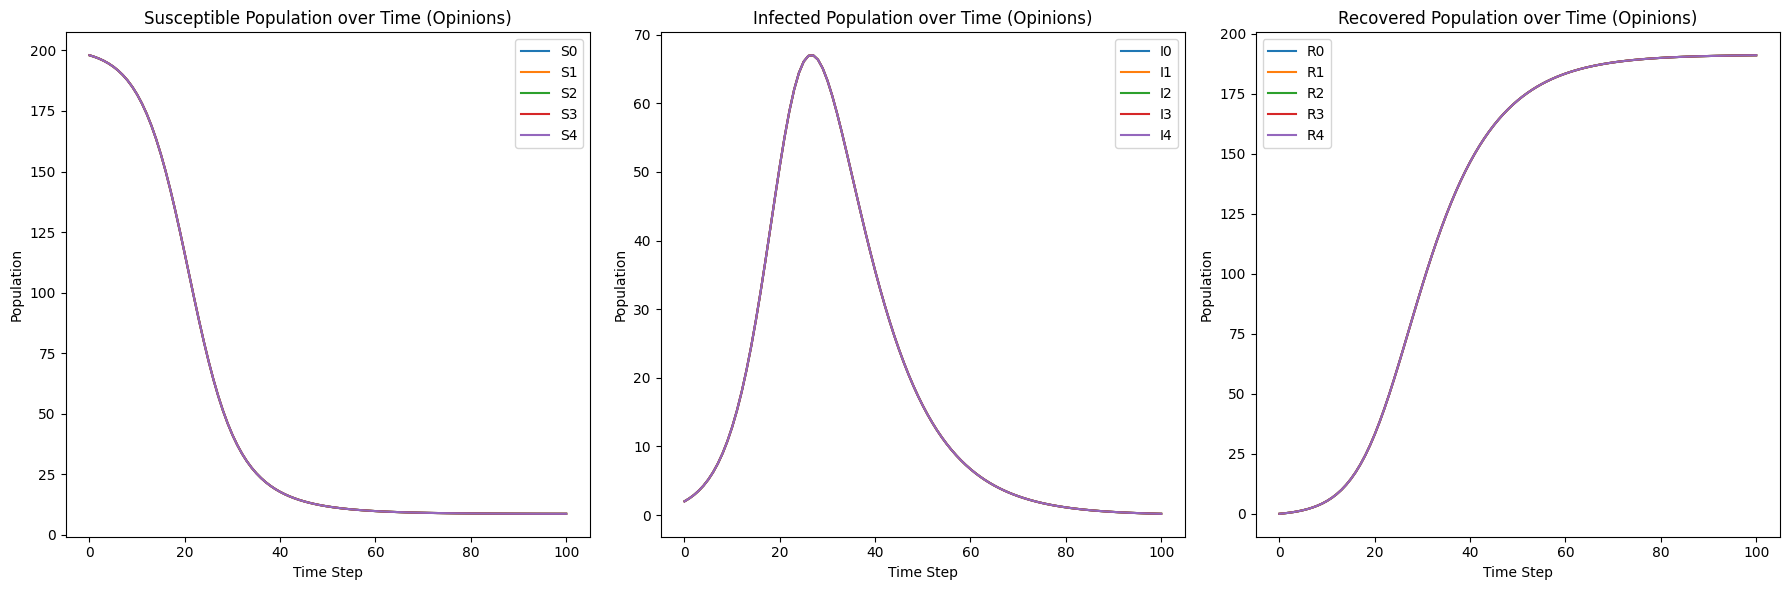

In [6]:
def plot_opinion_results(populations, n):
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i in range(n):
        S = [pop[i] for pop in populations]
        I = [pop[n+i] for pop in populations]
        R = [pop[2*n+i] for pop in populations]

        axs[0].plot(time, S, label=f'S{i}')
        axs[1].plot(time, I, label=f'I{i}')
        axs[2].plot(time, R, label=f'R{i}')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Susceptible Population over Time (Opinions)')
    axs[1].set_title('Infected Population over Time (Opinions)')
    axs[2].set_title('Recovered Population over Time (Opinions)')

    plt.tight_layout()
    plt.show()

plot_opinion_results(populations, n)

Plotting Function for Comparision between Basic and aggregated (Summed of Opinion) SIR 

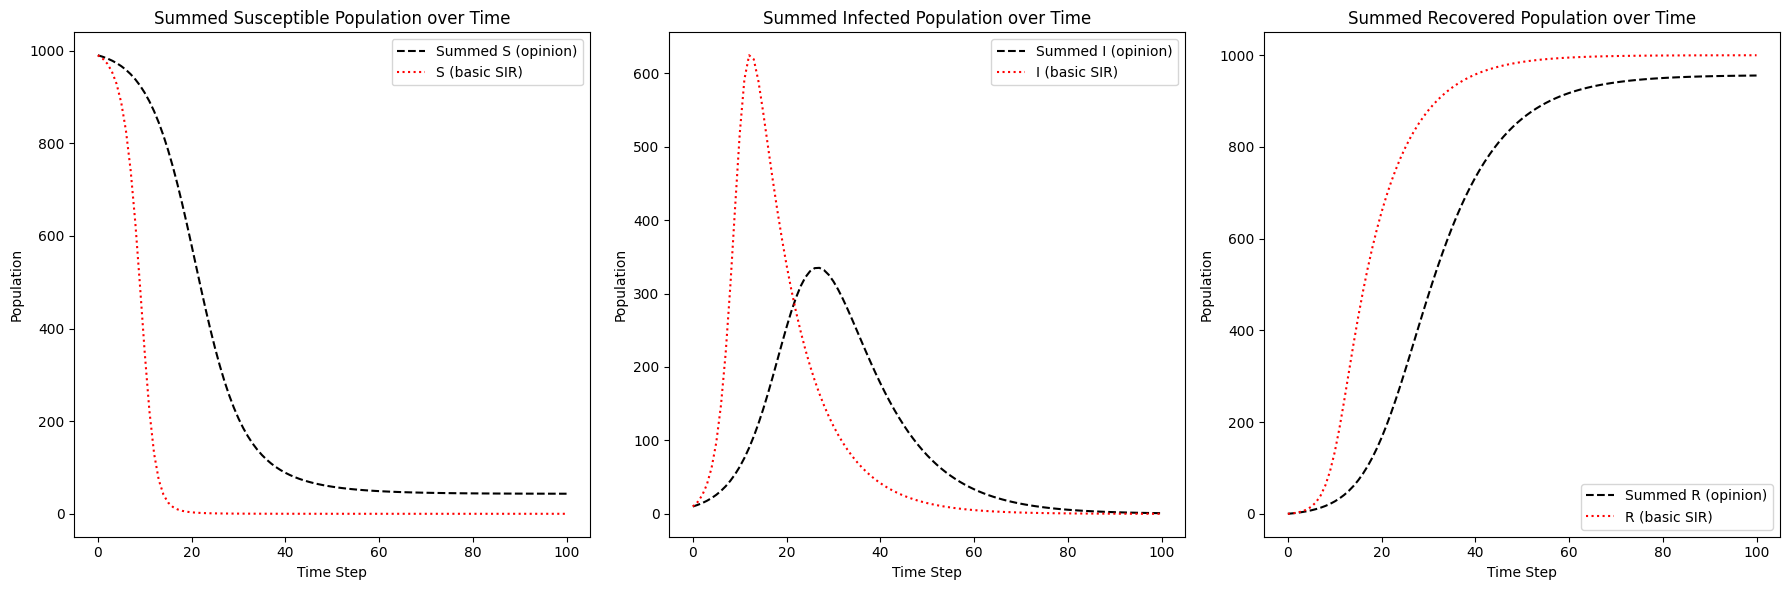

In [7]:
def plot_results(populations, basic_SIR_populations, n):
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Sum populations for opinion-based model
    S_total = [sum(pop[:n]) for pop in populations]
    I_total = [sum(pop[n:2*n]) for pop in populations]
    R_total = [sum(pop[2*n:3*n]) for pop in populations]

    axs[0].plot(time, S_total, label='Summed S (opinion)', linestyle='--', color='black')
    axs[1].plot(time, I_total, label='Summed I (opinion)', linestyle='--', color='black')
    axs[2].plot(time, R_total, label='Summed R (opinion)', linestyle='--', color='black')

    # Plot basic SIR model
    basic_S, basic_I, basic_R = zip(*basic_SIR_populations)
    axs[0].plot(time, basic_S, label='S (basic SIR)', linestyle=':', color='red')
    axs[1].plot(time, basic_I, label='I (basic SIR)', linestyle=':', color='red')
    axs[2].plot(time, basic_R, label='R (basic SIR)', linestyle=':', color='red')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Summed Susceptible Population over Time')
    axs[1].set_title('Summed Infected Population over Time')
    axs[2].set_title('Summed Recovered Population over Time')

    plt.tight_layout()
    plt.show()

plot_results(populations, basic_SIR_populations, n)


Plot function for SIR and aggregated SIR in 3D space as SIR being 3 axes

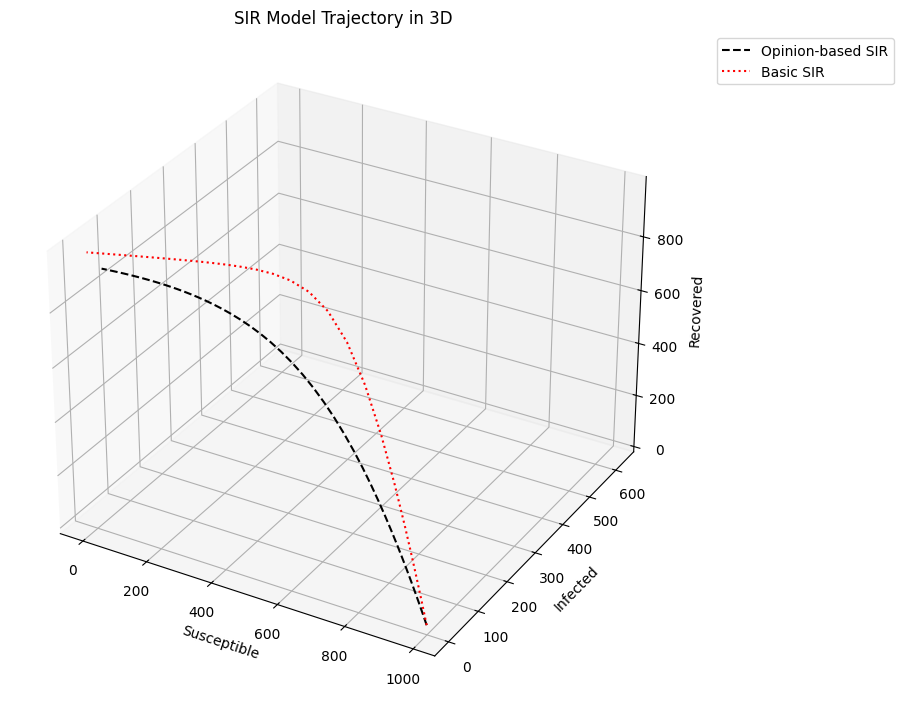

In [8]:
def plot_3d_results_2(populations, basic_SIR_populations):
    # Extract populations for opinion-based model
    n = len(populations[0]) // 3
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])

    # Extract populations for basic SIR model
    S_basic = np.array([pop[0] for pop in basic_SIR_populations])
    I_basic = np.array([pop[1] for pop in basic_SIR_populations])
    R_basic = np.array([pop[2] for pop in basic_SIR_populations])

    # Plotting the 3D trajectory
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(S_opinion, I_opinion, R_opinion, label='Opinion-based SIR', linestyle='--', color='black')
    ax.plot(S_basic, I_basic, R_basic, label='Basic SIR', linestyle=':', color='red')

    ax.set_xlabel('Susceptible')
    ax.set_ylabel('Infected')
    ax.set_zlabel('Recovered')
    ax.set_title('SIR Model Trajectory in 3D')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout(pad=4.0)

    plt.show()

plot_3d_results_2(populations, basic_SIR_populations)

Objective function to calculate the Error between Basic and aggregated SIR

In [9]:
# Optimization function to fit the parameters
def objective(params, init_state, q, steps, basic_SIR_populations, populations):
    beta, gamma = params
    
    # Simulate the opinion-based SIR model
    populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
    
    # Sum the opinion-based model results
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])
    
    # Extract the basic SIR model results
    S_basic, I_basic, R_basic = zip(*basic_SIR_populations)
    S_basic = np.array(S_basic)
    I_basic = np.array(I_basic)
    R_basic = np.array(R_basic)
    
    # Compute the mean squared error between the opinion-based model and the basic SIR model
    error = np.mean((S_opinion - S_basic)**2 + (I_opinion - I_basic)**2 + (R_opinion - R_basic)**2)
    
    return error


Simulation to find optimized beta gamma

In [10]:
# Initial guess for the optimization
initial_guess = [beta, gamma]


# Perform the optimization to find the best-fit beta and gamma
result = minimize(objective, initial_guess, args=(init_opinion_state, q, steps, basic_SIR_populations, populations), bounds=[(0, 1), (0, 1)])

# Extract the best-fit parameters
best_fit_beta, best_fit_gamma = result.x

best_fit_populations = simulate_transition(init_opinion_state, best_fit_beta, best_fit_gamma, steps, q)

print("Best fit beta:", best_fit_beta)
print("Best fit gamma:", best_fit_gamma)


Best fit beta: 1.0
Best fit gamma: 0.09758511239041567


Plot function for Basic, Optimized and aggregated SIR in 3D space as SIR being 3 axes

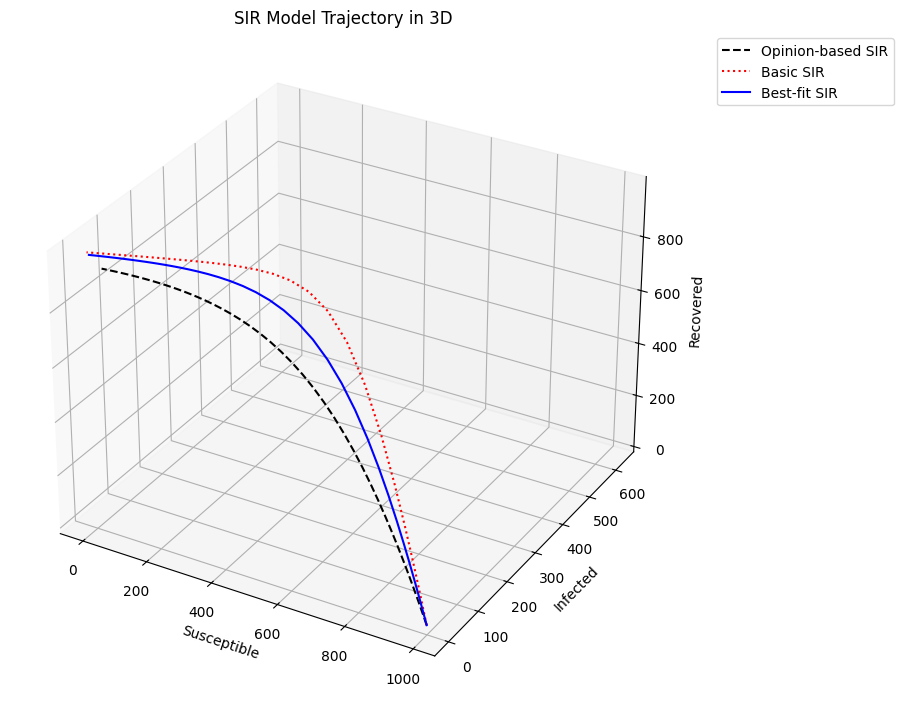

In [11]:
def plot_3d_results(populations, basic_SIR_populations, best_fit_populations):
    # Extract populations for opinion-based model
    n = len(populations[0]) // 3
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])

    # Extract populations for basic SIR model
    S_basic = np.array([pop[0] for pop in basic_SIR_populations])
    I_basic = np.array([pop[1] for pop in basic_SIR_populations])
    R_basic = np.array([pop[2] for pop in basic_SIR_populations])

    # Extract populations for best-fit SIR model
    S_best_fit = np.array([sum(pop[:n]) for pop in best_fit_populations])
    I_best_fit = np.array([sum(pop[n:2*n]) for pop in best_fit_populations])
    R_best_fit = np.array([sum(pop[2*n:3*n]) for pop in best_fit_populations])

    # Plotting the 3D trajectory
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(S_opinion, I_opinion, R_opinion, label='Opinion-based SIR', linestyle='--', color='black')
    ax.plot(S_basic, I_basic, R_basic, label='Basic SIR', linestyle=':', color='red')
    ax.plot(S_best_fit, I_best_fit, R_best_fit, label='Best-fit SIR', linestyle='-', color='blue')

    ax.set_xlabel('Susceptible')
    ax.set_ylabel('Infected')
    ax.set_zlabel('Recovered')
    ax.set_title('SIR Model Trajectory in 3D')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout(pad=4.0)
    plt.show()

plot_3d_results(populations, basic_SIR_populations,best_fit_populations)

Plotting Errors for Different beta & gamma Values

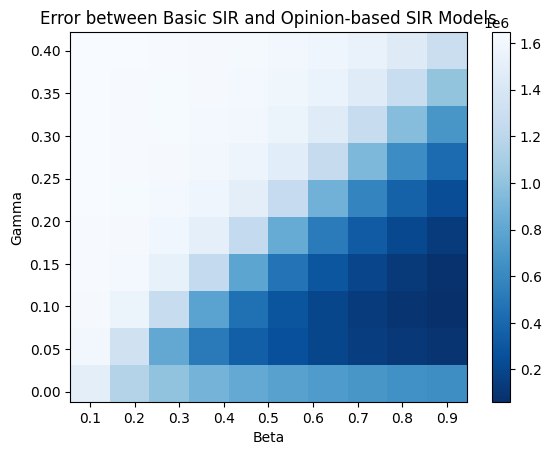

In [12]:
def diff_beta_gamma():
    # Define the range of beta and gamma values for the grid search
    beta_vals = np.linspace(0.1, 0.9, 10)
    gamma_vals = np.linspace(0.01, 0.4, 10)
    errors = np.zeros((len(beta_vals), len(gamma_vals)))

    # Compute the error for each combination of beta and gamma values
    for i, beta_a in enumerate(beta_vals):
        for j, gamma_a in enumerate(gamma_vals):
            
            errors[i, j] = objective([beta_a, gamma_a], init_opinion_state, q, steps, basic_SIR_populations, populations)


    # Plot the error heatmap
    fig, ax = plt.subplots()
    c = ax.pcolormesh(beta_vals, gamma_vals, errors.T, cmap='Blues_r', shading='auto')
    ax.set_xlabel('Beta')
    ax.set_ylabel('Gamma')
    fig.colorbar(c, ax=ax)
    plt.title('Error between Basic SIR and Opinion-based SIR Models')
    plt.show()
    
# Run the analysis for different beta and gamma values
diff_beta_gamma()

Plotting Errors for Different q sets

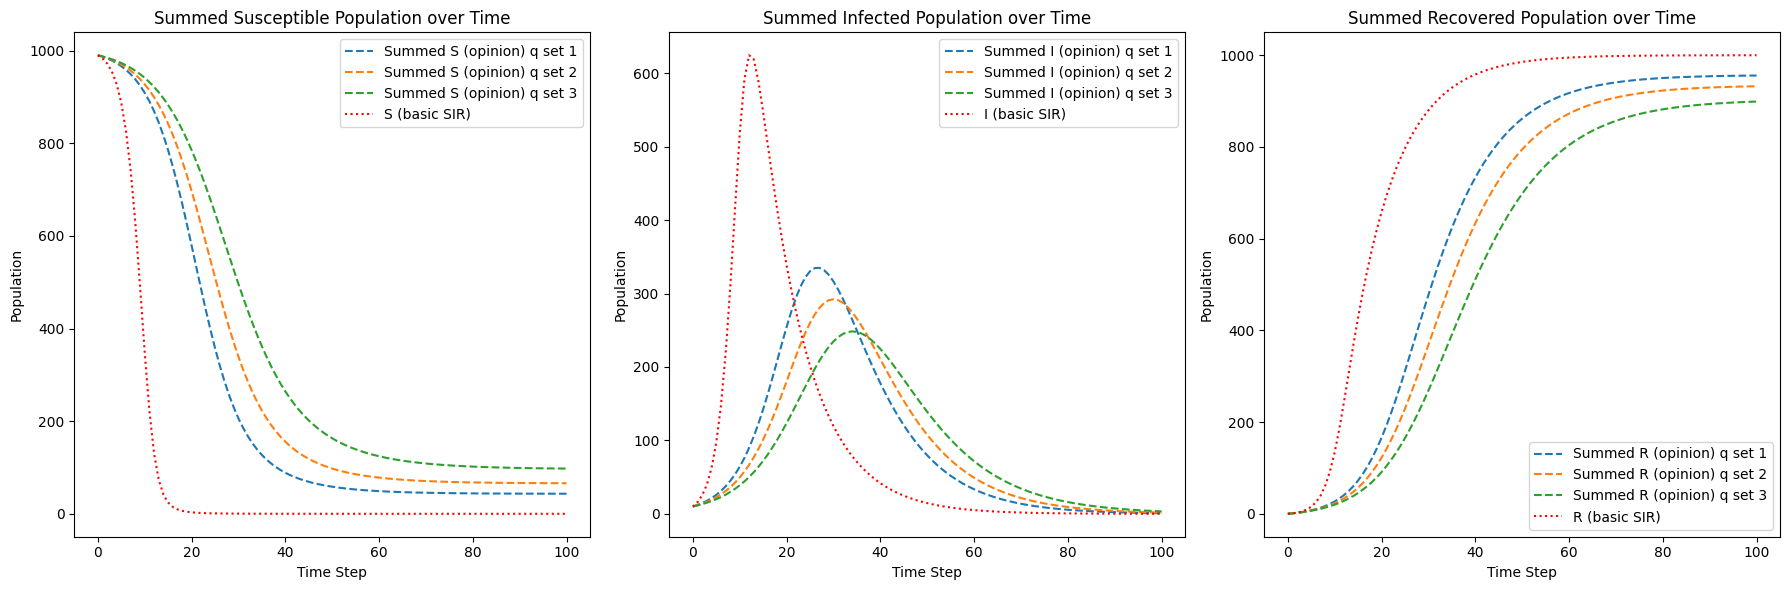

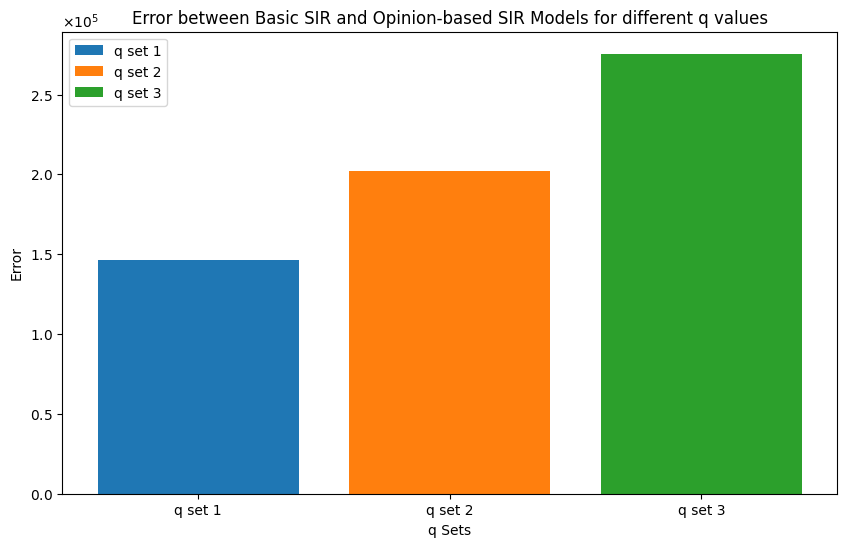

In [13]:
def diff_q_values(init_opinion_state, init_state, beta, gamma, steps, q_values, n):
    # Create an empty list to store errors for each q value set
    errors = []
    all_S_opinion = []
    all_I_opinion = []
    all_R_opinion = []
    
    # Iterate over each set of q values
    for q in q_values:
        # Simulate the opinion-based SIR model
        populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
        
        # Sum the opinion-based model results
        S_opinion = np.array([sum(pop[:n]) for pop in populations])
        I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
        R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])
        
        # Store the results for plotting
        all_S_opinion.append(S_opinion)
        all_I_opinion.append(I_opinion)
        all_R_opinion.append(R_opinion)
        
        # Simulate the basic SIR model
        basic_SIR_populations = simulate_basic_SIR(init_state, beta, gamma, steps)
        S_basic, I_basic, R_basic = zip(*basic_SIR_populations)
        S_basic = np.array(S_basic)
        I_basic = np.array(I_basic)
        R_basic = np.array(R_basic)
        
        # Compute the mean squared error
        error = np.mean((S_opinion - S_basic)**2 + (I_opinion - I_basic)**2 + (R_opinion - R_basic)**2)
        errors.append(error)
    
    # Plot the SIR model results
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, (S_opinion, I_opinion, R_opinion) in enumerate(zip(all_S_opinion, all_I_opinion, all_R_opinion)):
        axs[0].plot(time, S_opinion, label=f'Summed S (opinion) q set {i+1}', linestyle='--')
        axs[1].plot(time, I_opinion, label=f'Summed I (opinion) q set {i+1}', linestyle='--')
        axs[2].plot(time, R_opinion, label=f'Summed R (opinion) q set {i+1}', linestyle='--')

    # Plot basic SIR model
    axs[0].plot(time, S_basic, label='S (basic SIR)', linestyle=':', color='red')
    axs[1].plot(time, I_basic, label='I (basic SIR)', linestyle=':', color='red')
    axs[2].plot(time, R_basic, label='R (basic SIR)', linestyle=':', color='red')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Summed Susceptible Population over Time')
    axs[1].set_title('Summed Infected Population over Time')
    axs[2].set_title('Summed Recovered Population over Time')

    plt.tight_layout()
    plt.show()
    
    # Plot the error for each set of q values using histograms
    plt.figure(figsize=(10, 6))
    for i, error in enumerate(errors):
        plt.bar(i, error, label=f'q set {i+1}')

    plt.xlabel('q Sets')
    plt.ylabel('Error')
    plt.title('Error between Basic SIR and Opinion-based SIR Models for different q values')
    plt.xticks(range(len(errors)), [f'q set {i+1}' for i in range(len(errors))])

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
    plt.legend()
    plt.show()

    return errors

q_values = [np.array([-.1 * i for i in range(n)]), np.array([-.2* i for i in range(n)]), np.array([-.3 * i for i in range(n)])]

errors =diff_q_values(init_opinion_state, init_state, beta, gamma, steps, q_values, n)



Function for different beta, gamma and q sets

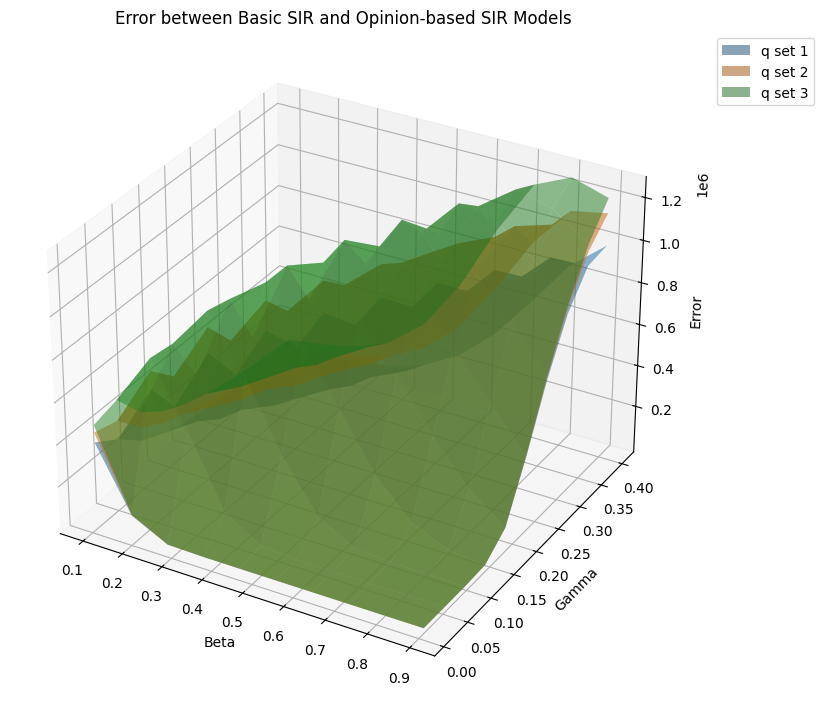

Error for q set 1: 146625.7473241818
Error for q set 2: 202166.06662873115
Error for q set 3: 275560.2485483091


In [14]:

def diff_beta_gamma_q(init_opinion_state, init_state, steps, n):
    # Define the range of beta and gamma values for the grid search
    beta_vals = np.linspace(0.1, 0.9, 10)
    gamma_vals = np.linspace(0.01, 0.4, 10)
    q_values = [np.array([-.1 * i for i in range(n)]), np.array([-.2* i for i in range(n)]), np.array([-.3 * i for i in range(n)])]
    errors = np.zeros((len(beta_vals), len(gamma_vals), len(q_values)))

    # Compute the error for each combination of beta, gamma, and q values
    for i, beta_a in enumerate(beta_vals):
        for j, gamma_a in enumerate(gamma_vals):
            for k, q in enumerate(q_values):
                # Simulate the opinion-based SIR model
                populations = simulate_transition(init_opinion_state, beta_a, gamma_a, steps, q)
                
                # Sum the opinion-based model results
                S_opinion = np.array([sum(pop[:n]) for pop in populations])
                I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
                R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])
                
                # Simulate the basic SIR model
                basic_SIR_populations = simulate_basic_SIR(init_state, beta_a, gamma_a, steps)
                S_basic, I_basic, R_basic = zip(*basic_SIR_populations)
                S_basic = np.array(S_basic)
                I_basic = np.array(I_basic)
                R_basic = np.array(R_basic)
                
                # Compute the mean squared error
                error = np.mean((S_opinion - S_basic)**2 + (I_opinion - I_basic)**2 + (R_opinion - R_basic)**2)
                errors[i, j, k] = error

    # Plot the error 3D surface
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    beta_vals, gamma_vals = np.meshgrid(beta_vals, gamma_vals)
    
    for k, q in enumerate(q_values):
        ax.plot_surface(beta_vals, gamma_vals, errors[:, :, k], label=f'q set {k+1}', alpha=0.5)

    ax.set_xlabel('Beta')
    ax.set_ylabel('Gamma')
    ax.set_zlabel('Error')
    plt.title('Error between Basic SIR and Opinion-based SIR Models')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout(pad=4.0)
    plt.show()

    return errors

# Run the analysis for different q values
diff_beta_gamma_q(init_opinion_state, init_state, steps, n)


for i, error in enumerate(errors):
    print(f'Error for q set {i+1}: {np.max(error)}')



# Opt the opinion after meeting

Time step 0: [100, 200, 50, 50, 0, 0], sum=400
Time step 1: [82.5, 157.5, 60.0, 80.0, 7.5, 12.5], sum=400.0
Time step 2: [61.2, 111.6, 70.8, 108.4, 18.0, 30.0], sum=399.99999999999994
Time step 3: [40.33, 70.54, 78.23, 127.06, 31.44, 52.4], sum=400.0
Time step 4: [24.23, 41.12, 78.93, 130.82, 46.84, 78.06], sum=400.00000000000006
Time step 5: [14.19, 23.75, 73.24, 121.97, 62.57, 104.28], sum=400.00000000000006
Time step 6: [8.67, 14.46, 64.12, 106.86, 77.21, 128.68], sum=400.00000000000006
Time step 7: [5.71, 9.51, 54.26, 90.43, 90.03, 150.05], sum=400.0000000000001
Time step 8: [4.06, 6.76, 45.06, 75.1, 100.89, 168.14], sum=400.0000000000001
Time step 9: [3.08, 5.13, 37.02, 61.7, 109.9, 183.16], sum=400.0000000000001
Time step 10: [2.47, 4.12, 30.23, 50.38, 117.3, 195.5], sum=400.0000000000001
Time step 11: [2.07, 3.46, 24.58, 40.97, 123.35, 205.58], sum=400.0000000000001
Time step 12: [1.8, 3.0, 19.94, 33.23, 128.26, 213.77], sum=400.00000000000006
Time step 13: [1.61, 2.68, 16.14, 2

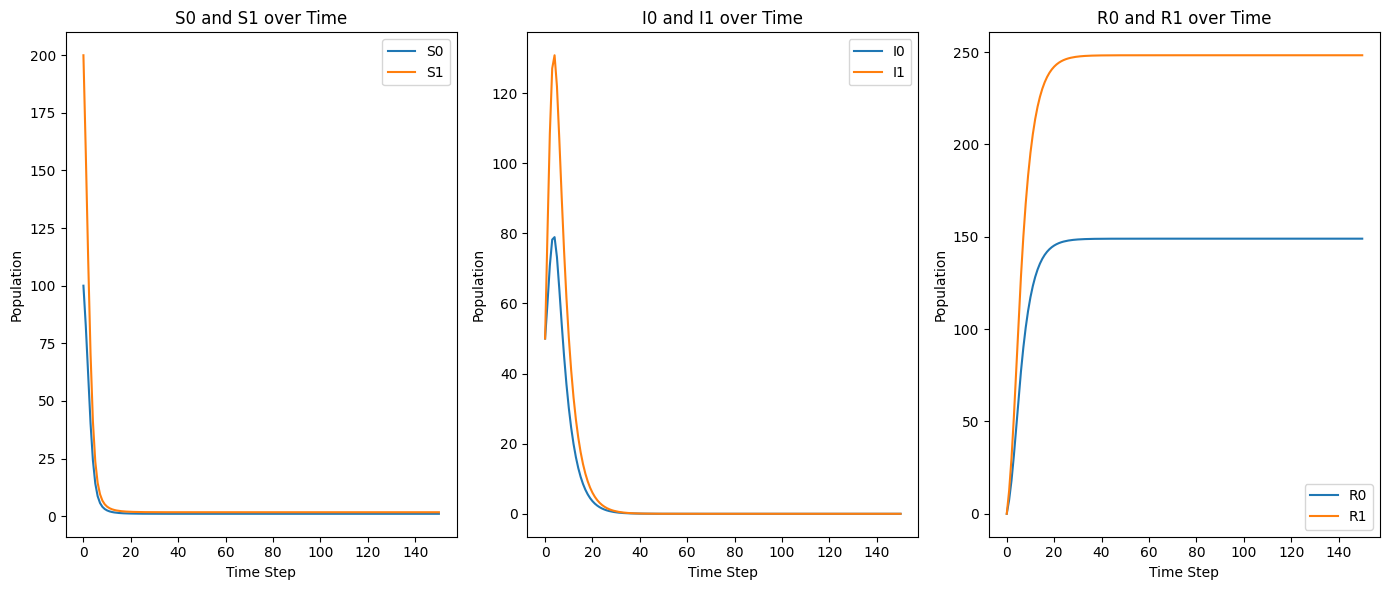

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q = [-10, -20]

def pii1(q):
    return 1 / (1 + np.exp(q))
def pii2(q):
    return np.exp(q) / (1 + np.exp(q))

def transition_matrix(beta, gamma, statevector):
    # statevector = [s0 s1 i0 i1 r0 r1]

    N = np.sum(statevector)
    ps0 = statevector[0] / N
    ps1 = statevector[1] / N
    pi0 = statevector[2] / N
    pi1 = statevector[3] / N
    pr0 = statevector[4] / N
    pr1 = statevector[5] / N

    matrix = np.zeros((6, 6))
    
    matrix[0, 0] = ps0 + pi0 * (pii1(-10) * (1-beta) + pii2(-10)) + pr0  # S0 -> S0
    matrix[0, 1] = ps1 + pi1 * (pii1(-10) * (1-beta) + pii2(-10)) + pr1  # S0 -> S1
    matrix[0, 2] = pi0 * pii1(-10) * beta  # S0 -> I0
    matrix[0, 3] = pi1 * pii1(-10) * beta  # S0 -> I1

    matrix[1, 0] = ps0 + pi0 * (pii1(-20) * (1-beta) + pii2(-20)) + pr0   # S1 -> S0
    matrix[1, 1] = ps1 + pi1 * (pii1(-20) * (1-beta) + pii2(-20)) + pr1  # S1 -> S1
    matrix[1, 2] = pi0 * pii1(-20) * beta  # S1 -> I0
    matrix[1, 3] = pi1 * pii1(-20) * beta  # S1 -> I1

    matrix[2, 2] = (1-gamma) * (ps0 + pi0 + pr0)  # I0 -> I0
    matrix[2, 3] = (1-gamma) * (ps1 + pi1 + pr1)  # I0 -> I1 
    matrix[2, 4] = gamma  * (ps0 + pi0 + pr0) # I0 -> R0
    matrix[2, 5] = gamma  * (ps1 + pi1 + pr1) # I0 -> R1

    matrix[3, 2] = (1-gamma) * (ps0 + pi0 + pr0)  # I1 -> I0
    matrix[3, 3] = (1-gamma) * (ps1 + pi1 + pr1)  # I1 -> I1 
    matrix[3, 4] = gamma  * (ps0 + pi0 + pr0) # I1 -> R0
    matrix[3, 5] = gamma  * (ps1 + pi1 + pr1) # I1 -> R1

    matrix[4, 4] = ps0 + pi0 + pr0  # R0 -> R0
    matrix[4, 5] = ps1 + pi1 + pr1  # R0 -> R1

    matrix[5, 5] = ps1 + pi1 + pr1  # R1 -> R0
    matrix[5, 4] = ps0 + pi0 + pr0  # R1 -> R1



    return matrix

def simulate_transition(population, beta, gamma, steps):
    """Simulate the population transitions over a number of steps."""
    populations = [np.array(population)]
    for _ in range(steps):
        matrix = transition_matrix(beta, gamma, populations[-1])
        population = populations[-1] @ matrix
        populations.append(population)
    return populations

init_state = np.array([100, 200, 50, 50, 0, 0])
beta = 0.8  # Example infection rate
gamma = 0.2  # Example recovery rate
steps = 150 # Number of time steps to simulate
populations = simulate_transition(init_state, beta, gamma, steps)

# Printing results
for i, pop in enumerate(populations):
    print(f"Time step {i}: {[round(pi,2) for pi in pop]}, sum={np.sum(pop)}")


def plot_results(populations):
    timesteps = len(populations)
    S0 = [pop[0] for pop in populations]
    S1 = [pop[1] for pop in populations]
    I0 = [pop[2] for pop in populations]
    I1 = [pop[3] for pop in populations]
    R0 = [pop[4] for pop in populations]
    R1 = [pop[5] for pop in populations]

    time = np.arange(timesteps)

    plt.figure(figsize=(14, 6))

    # Plot S0 and S1
    plt.subplot(1, 3, 1)
    plt.plot(time, S0, label='S0')
    plt.plot(time, S1, label='S1')
    plt.xlabel('Time Step')
    plt.ylabel('Population')
    plt.title('S0 and S1 over Time')
    plt.legend()

    # Plot I0 and I1
    plt.subplot(1, 3, 2)
    plt.plot(time, I0, label='I0')
    plt.plot(time, I1, label='I1')
    plt.xlabel('Time Step')
    plt.ylabel('Population')
    plt.title('I0 and I1 over Time')
    plt.legend()

    # Plot R0 and R1
    plt.subplot(1, 3, 3)
    plt.plot(time, R0, label='R0')
    plt.plot(time, R1, label='R1')
    plt.xlabel('Time Step')
    plt.ylabel('Population')
    plt.title('R0 and R1 over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
plot_results(populations)



# Dominance Model, when if other opinion is higher then one would opt it

Time step 0: [100, 100, 50, 50, 0, 0], sum=300
Time step 1: [36.67, 110.0, 33.33, 100.0, 5.0, 15.0], sum=300.0
Time step 2: [5.91, 88.62, 9.93, 148.88, 2.92, 43.75], sum=300.00000000000006
Time step 3: [0.21, 54.28, 0.65, 166.42, 0.31, 78.12], sum=300.0
Time step 4: [0.0, 30.22, 0.0, 157.94, 0.0, 111.84], sum=300.00000000000006
Time step 5: [0.0, 17.49, 0.0, 139.08, 0.0, 143.43], sum=300.0
Time step 6: [0.0, 11.0, 0.0, 117.75, 0.0, 171.25], sum=300.0000000000001
Time step 7: [0.0, 7.55, 0.0, 97.65, 0.0, 194.8], sum=300.0000000000001
Time step 8: [0.0, 5.58, 0.0, 80.09, 0.0, 214.33], sum=300.0000000000001
Time step 9: [0.0, 4.39, 0.0, 65.26, 0.0, 230.35], sum=300.0000000000001
Time step 10: [0.0, 3.63, 0.0, 52.98, 0.0, 243.4], sum=300.00000000000017
Time step 11: [0.0, 3.11, 0.0, 42.89, 0.0, 253.99], sum=300.00000000000017
Time step 12: [0.0, 2.76, 0.0, 34.67, 0.0, 262.57], sum=300.00000000000017
Time step 13: [0.0, 2.5, 0.0, 27.99, 0.0, 269.51], sum=300.00000000000017
Time step 14: [0.

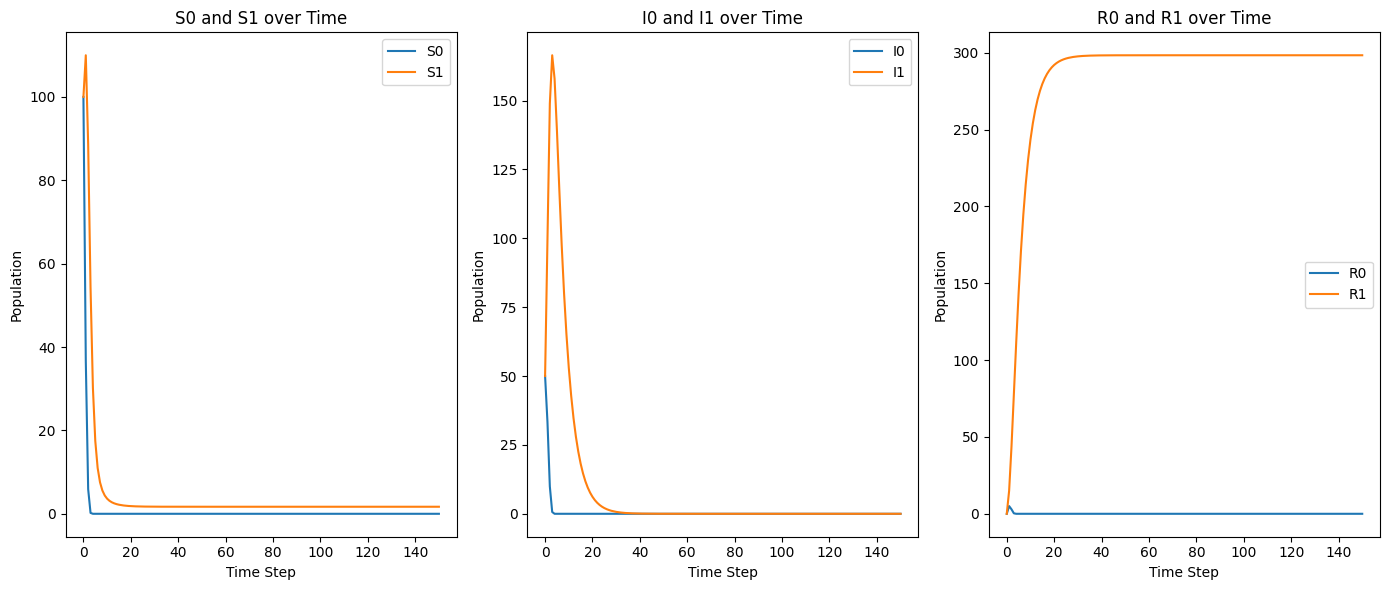

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q = [-10, -20]

def pii1(q):
    return 1 / (1 + np.exp(q))
def pii2(q):
    return np.exp(q) / (1 + np.exp(q))

def transition_matrix(beta, gamma, statevector):
    # statevector = [s0 s1 i0 i1 r0 r1]

    N = np.sum(statevector)
    ps0 = statevector[0] / N
    ps1 = statevector[1] / N
    pi0 = statevector[2] / N
    pi1 = statevector[3] / N
    pr0 = statevector[4] / N
    pr1 = statevector[5] / N

    matrix = np.zeros((6, 6))

    matrix[0, 0] = ps0 + pi0 * (pii1(-10) * (1-beta) + pii2(-10)) + pr0  # S0 -> S0
    matrix[0, 1] = ps1 + pi1 * (pii1(-10) * (1-beta) + pii2(-10)) + pr1  # S0 -> S1
    matrix[0, 2] = pi0 * pii1(-10) * beta  # S0 -> I0
    matrix[0, 3] = pi1 * pii1(-10) * beta  # S0 -> I1

    
    matrix[1, 1] = ps1 + pi1 * (pii1(-10) * (1-beta) + pii2(-10)) + pr1 + ps0 + pi0 * (pii1(-10) * (1-beta) + pii2(-10)) + pr0 # S1 -> S1
    matrix[1, 3] = pi1 * pii1(-10) * beta + pi0 * pii1(-10) * beta  # S1 -> I1

    matrix[2, 2] = (1-gamma) * (ps0 + pi0 + pr0)  # I0 -> I0
    matrix[2, 3] = (1-gamma) * (ps1 + pi1 + pr1)  # I0 -> I1 
    matrix[2, 4] = gamma  * (ps0 + pi0 + pr0) # I0 -> R0
    matrix[2, 5] = gamma  * (ps1 + pi1 + pr1) # I0 -> R1

    
    matrix[3, 3] = (1-gamma) * (ps1 + pi1 + pr1) + (1-gamma) * (ps0 + pi0 + pr0) # I1 -> I1 
    matrix[3, 5] = gamma  * (ps1 + pi1 + pr1) + gamma  * (ps0 + pi0 + pr0) # I1 -> R1

    matrix[4, 4] = ps0 + pi0 + pr0  # R0 -> R0
    matrix[4, 5] = ps1 + pi1 + pr1  # R0 -> R1

    matrix[5, 5] = ps1 + pi1 + pr1 + ps0 + pi0 + pr0 # R1 -> R0'



    return matrix

def simulate_transition(population, beta, gamma, steps):
    """Simulate the population transitions over a number of steps."""
    populations = [np.array(population)]
    for _ in range(steps):
        matrix = transition_matrix(beta, gamma, populations[-1])
        population = populations[-1] @ matrix
        populations.append(population)
    return populations

init_state = np.array([100, 100, 50, 50, 0, 0])
beta = 0.8  # Example infection rate
gamma = 0.2  # Example recovery rate
steps = 150 # Number of time steps to simulate
populations = simulate_transition(init_state, beta, gamma, steps)

# Printing results
for i, pop in enumerate(populations):
    print(f"Time step {i}: {[round(pi,2) for pi in pop]}, sum={np.sum(pop)}")


def plot_results(populations):
    timesteps = len(populations)
    S0 = [pop[0] for pop in populations]
    S1 = [pop[1] for pop in populations]
    I0 = [pop[2] for pop in populations]
    I1 = [pop[3] for pop in populations]
    R0 = [pop[4] for pop in populations]
    R1 = [pop[5] for pop in populations]

    time = np.arange(timesteps)

    plt.figure(figsize=(14, 6))

    # Plot S0 and S1
    plt.subplot(1, 3, 1)
    plt.plot(time, S0, label='S0')
    plt.plot(time, S1, label='S1')
    plt.xlabel('Time Step')
    plt.ylabel('Population')
    plt.title('S0 and S1 over Time')
    plt.legend()

    # Plot I0 and I1
    plt.subplot(1, 3, 2)
    plt.plot(time, I0, label='I0')
    plt.plot(time, I1, label='I1')
    plt.xlabel('Time Step')
    plt.ylabel('Population')
    plt.title('I0 and I1 over Time')
    plt.legend()

    # Plot R0 and R1
    plt.subplot(1, 3, 3)
    plt.plot(time, R0, label='R0')
    plt.plot(time, R1, label='R1')
    plt.xlabel('Time Step')
    plt.ylabel('Population')
    plt.title('R0 and R1 over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
plot_results(populations)

